In [41]:
'''やること
異常値検出のメジャーなアルゴリズムである「iForest」をやってみよう
sklearnのハンズオンをそのままコピペっている。
http://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py

・モデル分類器の各パラメーターについて
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
'''


'''アルゴリズムの概要
①アンサンブル学習（決定木分析を利用）を利用した異常値検出のアルゴリズムです
②ランダムに「特徴量」＆「値」を選択し、決定木を成長させていく。（同じ値のデータのみになったら成長を止める）
③たくさんの決定木（分離木とも呼ぶ）を作成し、各データポイントの「属するリーフの深さの平均」をとる
④異常値のデータは、「少ない分割で特定が可能」という前提に基づく
⑤木のアンサンブルで過学習を防げる一方、識別超平面が複雑になりがちです。
⑥機械学習ベースで異常値検出をする際には、一般的に当てはまることかもしれませんが「教師あり」、「教師なし」のどちらの方が絶対にいいというのはない。
（教師なし学習では、正常データのみを扱う。これで「自分でも自覚できていない異常値も判断できる）
⑦これも「機械学習ベースで異常値検出をする」際には一般的に当てはまることですが、
　　　閾値の決め方は「誤検出を減らしたいか、見逃しを減らしたいかのどちらに重きに置くか」によって変わる
'''


'''参考文献
・iForestの概要を把握する
https://www.slideshare.net/shogoosawa581/2-isolation-forest

・概要理解にはこちらもいい感じです
https://www.slideshare.net/KosukeNakago/dllab-20180214-88470902
'''


'''パラメータ
n_estimators:生成する木の数。多い方が計算結果が安定するものの、処理に時間がかかる。
max_samples:各決定木に適用するデータサイズ。多い方が計算結果が安定するものの、処理に時間がかかる。
contamination:外れ値と認定するデータの割合。
'''


'''流れ
1.sklearnのチュートリアルを参考に一回iForestを動かしてみる
ただし、乱数で生成したデータを使って「教師なし学習」で実施する
2.教師あり学習でもやってみる。
ハイパーパラメータをgridsearchで調節する
'''

'流れ\n1.sklearnのチュートリアルを参考に一回iForestを動かしてみる\nただし、乱数で生成したデータを使って「教師な学習」を実施する\n2.教師あり学習でもやってみる。\nハイパーパラメータをgridsearchで調節する\n'

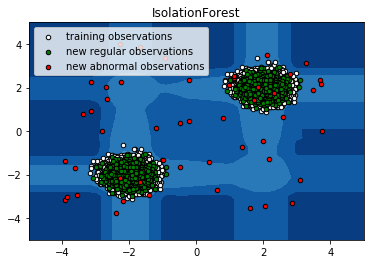

In [2]:
'''sklearnのチュートリアルをほとんどそのままコピペ
乱数でサンプルデータを作成しモデル生成。
サンプルデータはトレーニング、テスト、外れ値と３回に分けて生成している。

グリッドサーチ、交差検定等を全くしないで、いきなりモデル生成している。
'''

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
% matplotlib inline

rng = np.random.RandomState(42)

# Generate train data(2,10000の配列データを作るよ。実際に使う時は値を正規化した配列を突っ込むよ)
X = 0.3 * rng.randn(10000, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(2000, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(50, 2))

# fit the model
clf = IsolationForest(n_estimators= 1000, # 決定木を1000個
                      max_samples=1000, # 各決定木に適用するサンプルサイズは1000個
                      max_features=1.0, # 全ての特徴量を利用する
                      bootstrap=False, # bootstrap的にやらずに、各学習器を独立させる。
                      n_jobs=-1, # コアを全て使って並列処理
                      random_state=rng  # 何回実行しても同じ結果になるように指定しておく。あってもなくてもいいかな
                     ) 
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green',
                 s=20, edgecolor='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", 
            "new abnormal observations"],
           loc="upper left")
plt.show()


In [3]:
'''細かいことの確認
'''

# モデルに指定したパラメータの確認
parameter_train = clf.get_params(deep=True)
print('parameter_train:"{}\n'.format(parameter_train))

# 各データポイントのアノマリティーを数値で表示(アノマリティーが高い順にソートして、そのデータポイントのIDを表示したい。)
anormaly = clf.decision_function(X_train)
print('anormaly:{}\n'.format(anormaly))


parameter_train:"{'bootstrap': False, 'contamination': 0.1, 'max_features': 1.0, 'max_samples': 1000, 'n_estimators': 1000, 'n_jobs': -1, 'random_state': <mtrand.RandomState object at 0x10786f3a8>, 'verbose': 0}

anormaly:[ 0.07465456  0.01836966  0.08036102 ...  0.06559909  0.03880937
 -0.04910529]



In [4]:
'''ハイパーパラメータの調節をしようとしたけど、教師なし学習だから無理だね。
（ハイパーパラメータを変更した後の評価ができない）

教師あり学習で、精度を評価する練習のためのサンプルデータを作成する

'''

# テスト用配列をもう一つ作ってみる
x_work = np.r_[X_test, X_outliers]
print(x_work.shape)
print(x_work)

# 教師あり学習にするために、正解配列を作成
y_test = np.ones((4000, 1))
y_outliers = np.zeros((50, 1))
y_work = np.r_[y_test, y_outliers]
print(y_work.shape)
print(y_work)

(4050, 2)
[[ 2.10448587  2.08499708]
 [ 1.71904405  2.17387527]
 [ 1.5529752   1.8037447 ]
 ...
 [ 1.99112182 -0.4616058 ]
 [-0.9825585  -1.33570189]
 [ 3.71955852  2.17578729]]
(4050, 1)
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]


In [36]:
'''上記で作成したwork用データでiForestモデルを生成
（グリッドサーチでハイパーパラメーターを調整）
サンプルサイズは4050。そのうち５０サンプルが外れ値なので、全てを正常値といっても精度は80%程度にはなる。
（精度が高々85％程度なので、大したことない。サンプルデータが２次元で値も適当だからこんなものか）
'''
from sklearn.model_selection import GridSearchCV

# チューニングするパラメータを指定
param_grid = [
  {'n_estimators': [100, 300, 500, 1000], 'max_samples': [100, 500, 1000, 2000], 'max_features':[0.5, 1.0], 'bootstrap':['False', 'True']},
 ]

# モデル生成
clf = GridSearchCV(IsolationForest(), 
                   param_grid, 
                   scoring="accuracy", # 教師あり学習なので、単純な精度で検証を進める
                   cv=5,  # 交差検証(5個に分割)
                   n_jobs=-1)

clf.fit(x_work, y_work)

GridSearchCV(cv=5, error_score='raise',
       estimator=IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
        verbose=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [100, 300, 500, 1000], 'max_samples': [100, 500, 1000, 2000], 'max_features': [0.5, 1.0], 'bootstrap': ['False', 'True']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [37]:
'''精度評価
sklearnが0.20以降になった場合を想定した仕様だが、ベストなパラメータのみしか確認できていない。
上と同じように「各パラメータでどのように精度が推移したか」を知りたいので要調査
'''

# 各パラメータごとの精度を表示する
for i in range(len(clf.cv_results_['param_bootstrap'])):
    params_i =  clf.cv_results_['params'][i]
    score_test_i = clf.cv_results_['mean_test_score'][i]
    std_test_i  = clf.cv_results_['std_test_score'][i]
    
    print("{0},精度:{1} ,標準誤差=(+/- {2})".format(params_i, round(score_test_i, 2), round(std_test_i/2, 2)))


# 最高精度をはじき出した際のパラメータを表示
print("========================")
print("best parameters: {}".format(clf.best_params_))
print("best score:      {:0.5f} (+/-{:0.5f})".format(clf.best_score_, clf.cv_results_['std_test_score'][clf.best_index_]))

{'bootstrap': 'False', 'max_features': 0.5, 'max_samples': 100, 'n_estimators': 100},精度:0.81 ,標準誤差=(+/- 0.03)
{'bootstrap': 'False', 'max_features': 0.5, 'max_samples': 100, 'n_estimators': 300},精度:0.82 ,標準誤差=(+/- 0.03)
{'bootstrap': 'False', 'max_features': 0.5, 'max_samples': 100, 'n_estimators': 500},精度:0.81 ,標準誤差=(+/- 0.03)
{'bootstrap': 'False', 'max_features': 0.5, 'max_samples': 100, 'n_estimators': 1000},精度:0.82 ,標準誤差=(+/- 0.03)
{'bootstrap': 'False', 'max_features': 0.5, 'max_samples': 500, 'n_estimators': 100},精度:0.84 ,標準誤差=(+/- 0.02)
{'bootstrap': 'False', 'max_features': 0.5, 'max_samples': 500, 'n_estimators': 300},精度:0.84 ,標準誤差=(+/- 0.02)
{'bootstrap': 'False', 'max_features': 0.5, 'max_samples': 500, 'n_estimators': 500},精度:0.83 ,標準誤差=(+/- 0.02)
{'bootstrap': 'False', 'max_features': 0.5, 'max_samples': 500, 'n_estimators': 1000},精度:0.84 ,標準誤差=(+/- 0.02)
{'bootstrap': 'False', 'max_features': 0.5, 'max_samples': 1000, 'n_estimators': 100},精度:0.83 ,標準誤差=(+/- 0.03)
{'boots